In [1]:
!pip install imantics --quiet

In [2]:
import os
import cv2
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import imantics
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
base_dir = '/kaggle/input/satellitegooglemapsmasks/content/drive/MyDrive/Google maps'

images_dir ='/kaggle/input/satellitegooglemapsmasks/content/drive/MyDrive/Google maps/train/images'
masks_dir = '/kaggle/input/satellitegooglemapsmasks/content/drive/MyDrive/Google maps/train/label'

test_images_dir='/kaggle/input/satellitegooglemapsmasks/content/drive/MyDrive/Google maps/val/images'
test_masks_dir='/kaggle/input/satellitegooglemapsmasks/content/drive/MyDrive/Google maps/val/label'

In [4]:
images_listdir = os.listdir(images_dir)
masks_listdir = os.listdir(masks_dir)
random_images = np.random.choice(masks_listdir, size = 9, replace = False)
test_images_listdir = os.listdir(test_images_dir)
test_masks_listdir = os.listdir(test_masks_dir)

In [5]:
print(len(images_listdir))
print(len(masks_listdir))
print(len(test_images_listdir))
print(len(test_masks_listdir))

1033
1033
1074
1074


In [6]:
image_size=512
input_image_size=(512,512)

In [7]:
def read_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (image_size, image_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [8]:
number=30

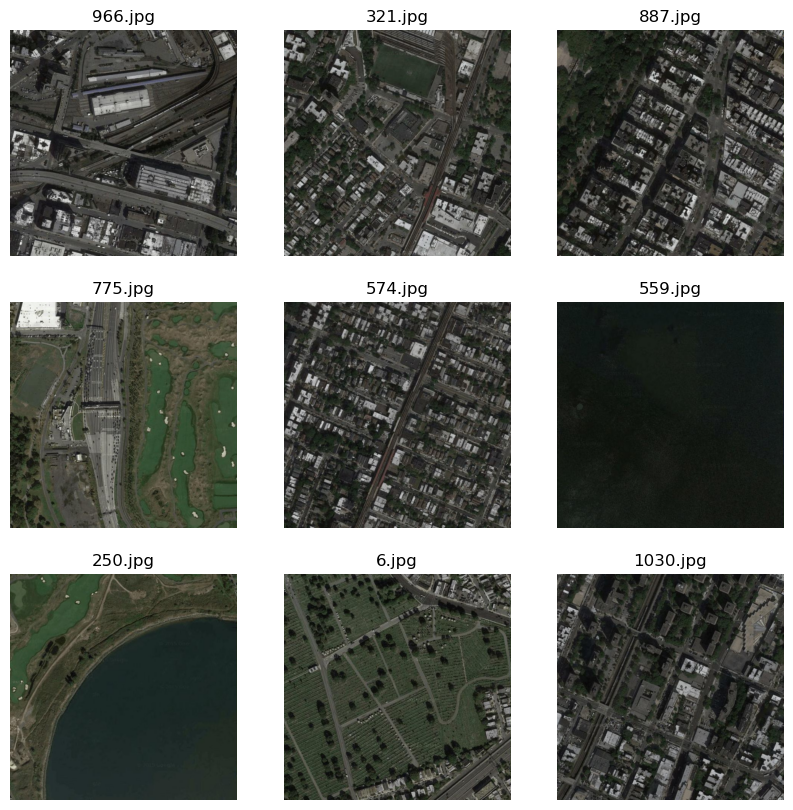

In [9]:
rows = 3
cols = 3
fig, ax = plt.subplots(rows, cols, figsize = (10,10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        img = read_image(f"{images_dir}/{random_images[i]}")
        ax.set_title(f"{random_images[i]}")
        ax.imshow(img)
        ax.axis('off')

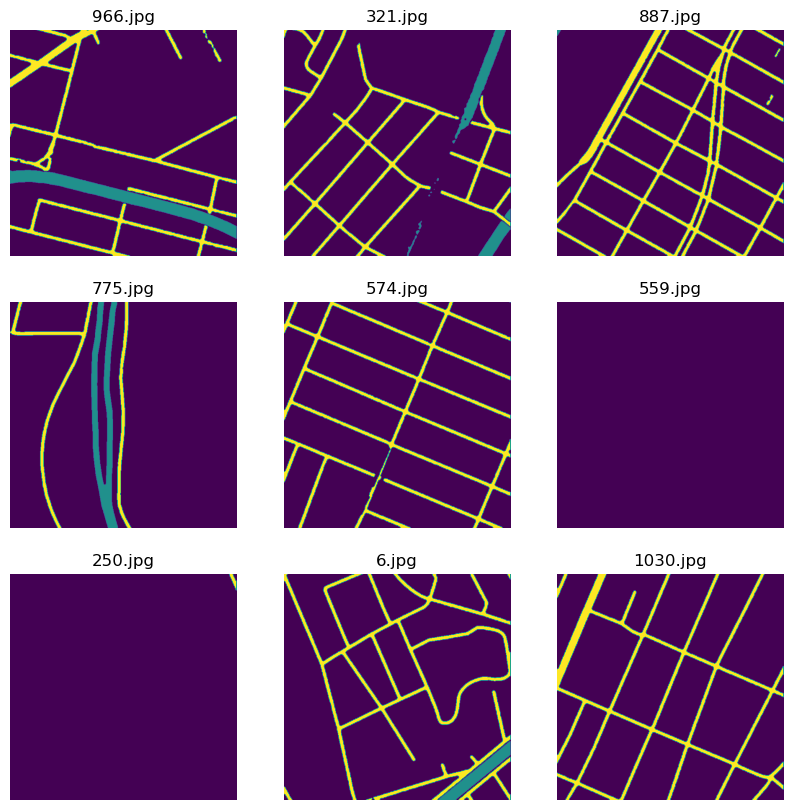

In [10]:
fig, ax = plt.subplots(rows, cols, figsize = (10,10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        file=random_images[i]
        if os.path.exists(os.path.join(masks_dir,file)):
            img = read_image(f"{masks_dir}/{file}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ax.set_title(f"{random_images[i]}")
            ax.imshow(img)
            ax.axis('off')
        else:
            print('not exist')

In [11]:
MASKS=np.zeros((1,image_size, image_size, 1), dtype=bool)
IMAGES=np.zeros((1,image_size, image_size, 3),dtype=np.uint8)

for j,file in enumerate(masks_listdir[0:number]): ##the smaller, the faster
    try:
        image = read_image(f"{images_dir}/{file}")
        image_ex = np.expand_dims(image, axis=0)
        IMAGES = np.vstack([IMAGES, image_ex])
        file2=file[0:-4]+'.jpg'
        mask = read_image(f"{masks_dir}/{file2}")    
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = mask.reshape(512,512,1)
        mask_ex = np.expand_dims(mask, axis=0)    
        MASKS = np.vstack([MASKS, mask_ex])
    except:
        print(file)
        continue

In [12]:
TMASKS=np.zeros((1,image_size,image_size,1), dtype=bool)
TIMAGES=np.zeros((1,image_size,image_size,3),dtype=np.uint8)

for j,file in enumerate(test_images_listdir): ##the smaller, the faster
    try:
        image = read_image(f"{test_images_dir}/{file}")
        image_ex = np.expand_dims(image, axis=0)
        TIMAGES = np.vstack([TIMAGES, image_ex])
        file2=file[0:-4]+'.jpg'
        mask = read_image(f"{test_masks_dir}/{file2}") 
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = mask.reshape(512,512,1)
        mask_ex = np.expand_dims(mask, axis=0)    
        TMASKS = np.vstack([TMASKS, mask_ex])        
    except:
        print(file)
        continue

In [13]:
images=np.array(IMAGES)[1:number]
masks=np.array(MASKS)[1:number]
print(images.shape,masks.shape)

test_images=np.array(TIMAGES)[1:20]
test_masks=np.array(TMASKS)[1:20]
print(test_images.shape,test_masks.shape)

(29, 512, 512, 3) (29, 512, 512, 1)
(19, 512, 512, 3) (19, 512, 512, 1)


In [14]:
images_train, images_test, masks_train, masks_test = train_test_split(
    images, masks, test_size=0.2, random_state=42)

In [15]:
print(len(images_train), len(masks_train))

23 23


In [16]:
def conv_block(input, num_filters):
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(conv)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    return conv

def encoder_block(input, num_filters):
    skip = conv_block(input, num_filters)
    pool = tf.keras.layers.MaxPool2D((2, 2))(skip)
    return skip, pool

def decoder_block(input, skip, num_filters):
    up_conv = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    conv = tf.keras.layers.Concatenate()([up_conv, skip])
    conv = conv_block(conv, num_filters)
    return conv

def Unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    skip1, pool1 = encoder_block(inputs, 64)
    skip2, pool2 = encoder_block(pool1, 128)
    skip3, pool3 = encoder_block(pool2, 256)
    skip4, pool4 = encoder_block(pool3, 512)

    bridge = conv_block(pool4, 1024)

    decode1 = decoder_block(bridge, skip4, 512)
    decode2 = decoder_block(decode1, skip3, 256)
    decode3 = decoder_block(decode2, skip2, 128)
    decode4 = decoder_block(decode3, skip1, 64)

    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(decode4)

    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model

unet_model = Unet((512,512,3))
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#unet_model.summary()

In [17]:
unet_result = unet_model.fit(
    images_train, masks_train, 
    validation_split = 0.2, batch_size = 4, epochs = 100)

Epoch 1/100
5/5 [==============================] - 43s 3s/step - loss: -35.5661 - accuracy: 0.3531 - val_loss: 8529.7637 - val_accuracy: 0.8304
Epoch 2/100
5/5 [==============================] - 2s 426ms/step - loss: -101.4697 - accuracy: 0.5003 - val_loss: -1105660.0000 - val_accuracy: 0.0608
Epoch 3/100
5/5 [==============================] - 2s 425ms/step - loss: -136.1957 - accuracy: 0.5460 - val_loss: 550960.3750 - val_accuracy: 0.8304
Epoch 4/100
5/5 [==============================] - 2s 453ms/step - loss: -152.7415 - accuracy: 0.5584 - val_loss: 91058.0703 - val_accuracy: 0.7461
Epoch 5/100
5/5 [==============================] - 2s 425ms/step - loss: -193.0742 - accuracy: 0.5650 - val_loss: 10654.6855 - val_accuracy: 0.8280
Epoch 6/100
5/5 [==============================] - 2s 454ms/step - loss: -213.3498 - accuracy: 0.5271 - val_loss: -255368.4688 - val_accuracy: 0.2892
Epoch 7/100
5/5 [==============================] - 2s 426ms/step - loss: -213.2999 - accuracy: 0.3004 - val_lo

In [18]:
def show_result(idx, og, unet, target, p):
    
    fig, axs = plt.subplots(1, 3, figsize=(12,12))
    axs[0].set_title("Original "+str(idx))
    axs[0].imshow(og)
    axs[0].axis('off')
    
    axs[1].set_title("U-Net: p>"+str(p))
    axs[1].imshow(unet)
    axs[1].axis('off')
    
    axs[2].set_title("Ground Truth")
    axs[2].imshow(target)
    axs[2].axis('off')

    plt.show()

In [19]:
unet_predict = unet_model.predict(images_test)

1/1 [==============================] - 7s 7s/step


In [20]:
r1,r2,r3,r4=0.6,0.7,0.8,0.9

In [21]:
unet_predict1 = (unet_predict > r1).astype(np.uint8)
unet_predict2 = (unet_predict > r2).astype(np.uint8)
unet_predict3 = (unet_predict > r3).astype(np.uint8)
unet_predict4 = (unet_predict > r4).astype(np.uint8)

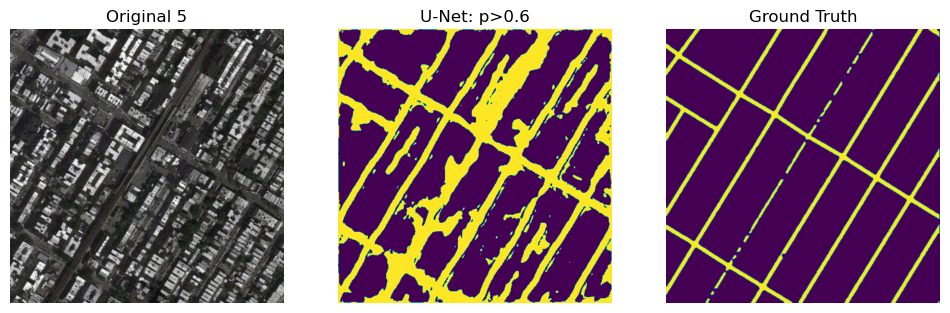

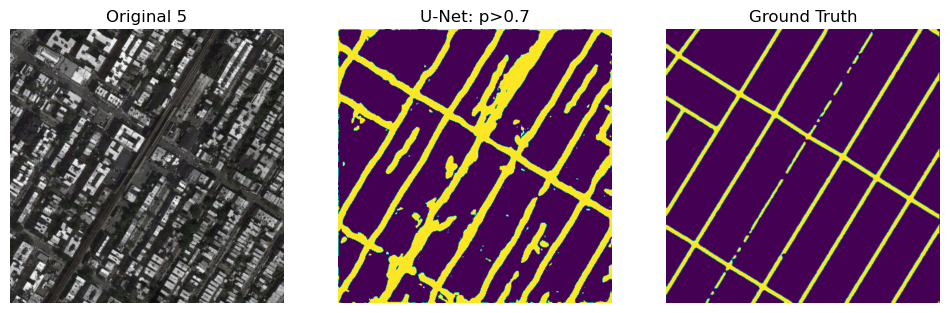

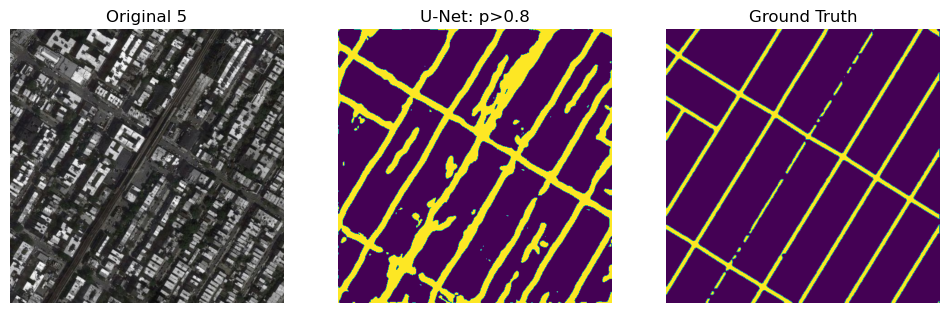

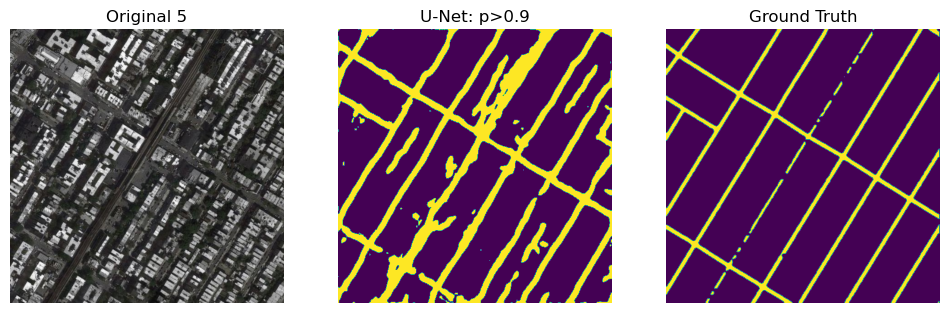

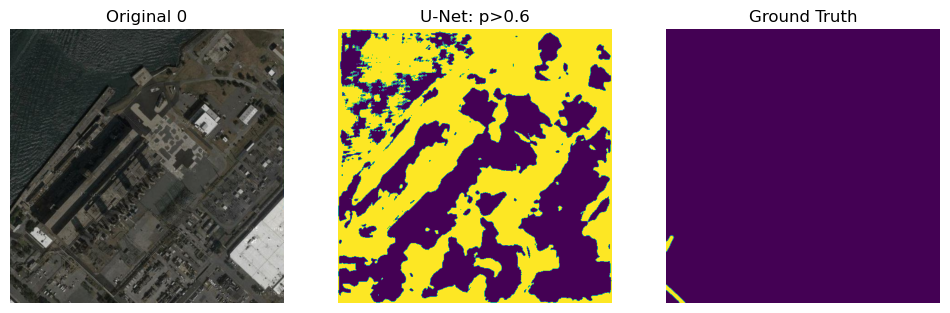

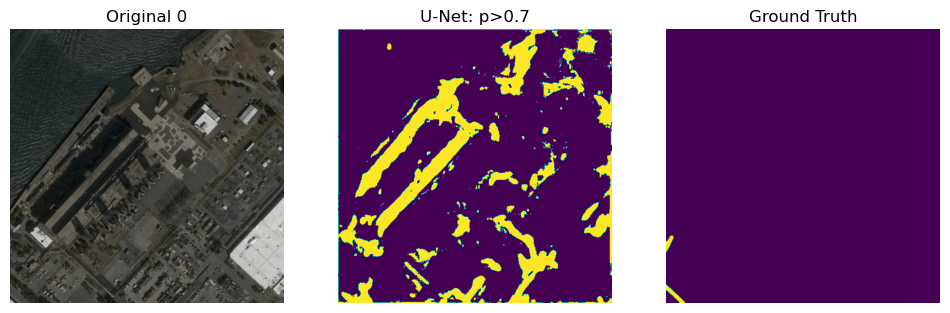

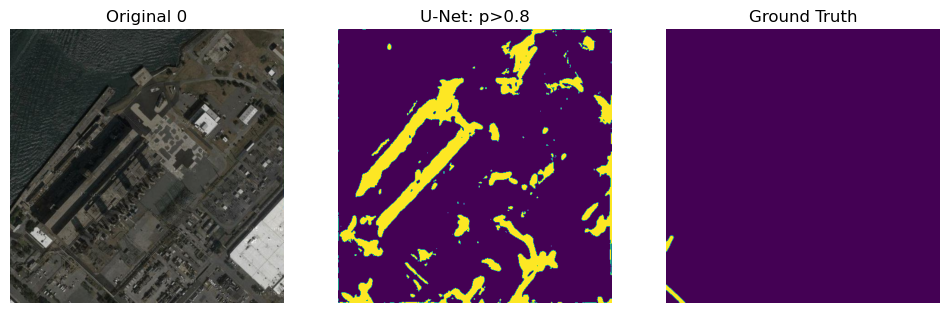

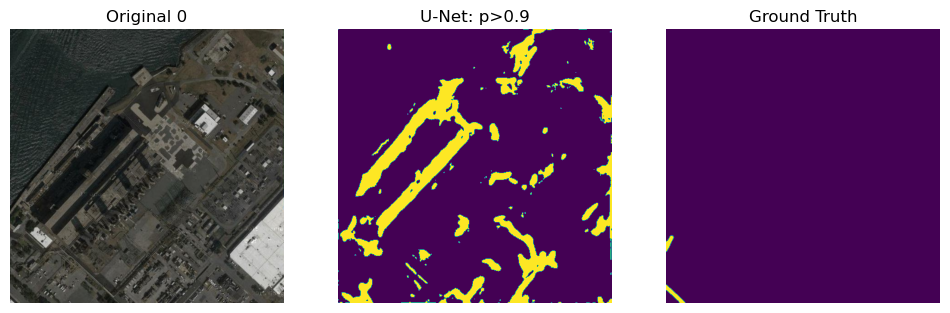

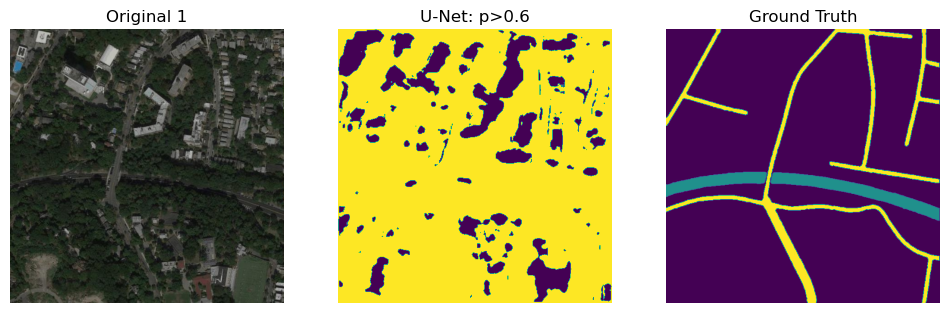

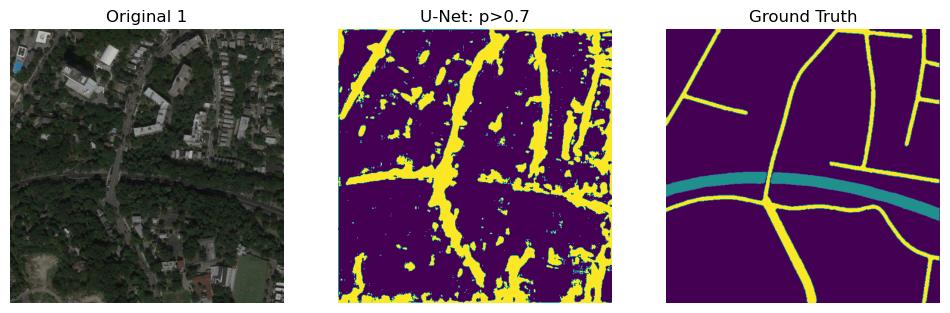

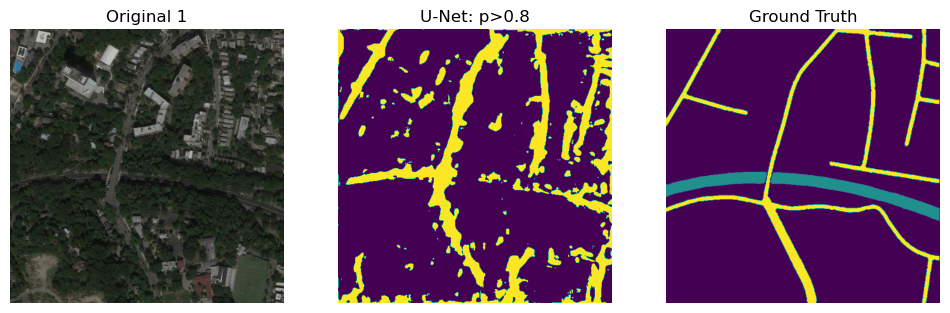

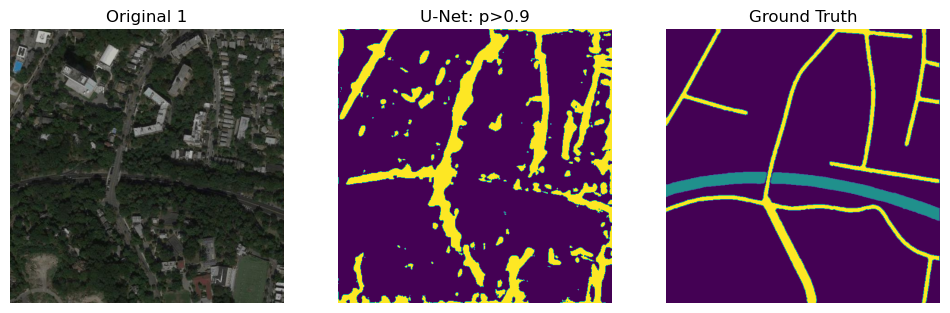

In [22]:
show_test_idx = random.sample(range(len(unet_predict)), 3)
for idx in show_test_idx: 
    show_result(idx, images_test[idx], unet_predict1[idx], masks_test[idx], r1)
    show_result(idx, images_test[idx], unet_predict2[idx], masks_test[idx], r2)
    show_result(idx, images_test[idx], unet_predict3[idx], masks_test[idx], r3)
    show_result(idx, images_test[idx], unet_predict4[idx], masks_test[idx], r4)
    print()

In [23]:
unet_predictT = unet_model.predict(test_images)

1/1 [==============================] - 17s 17s/step


In [24]:
unet_predict1 = (unet_predictT > r1).astype(np.uint8)
unet_predict2 = (unet_predictT > r2).astype(np.uint8)
unet_predict3 = (unet_predictT > r3).astype(np.uint8)
unet_predict4 = (unet_predictT > r4).astype(np.uint8)

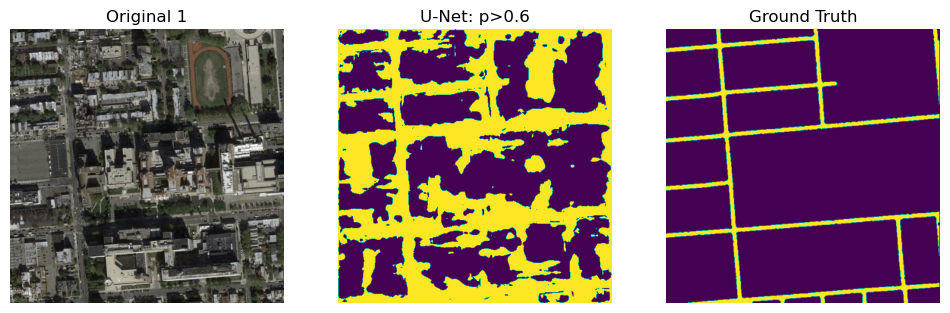

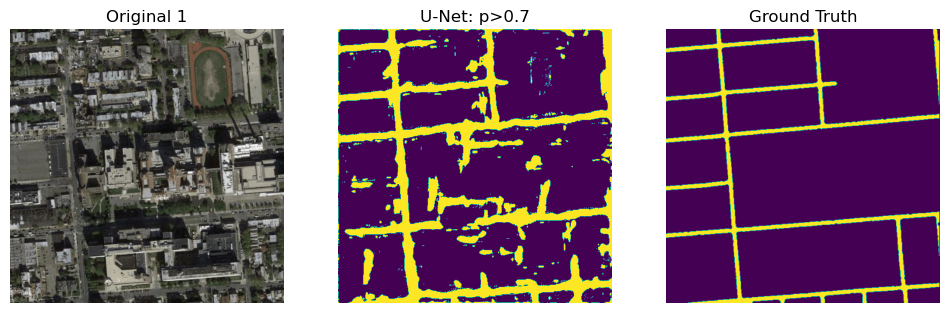

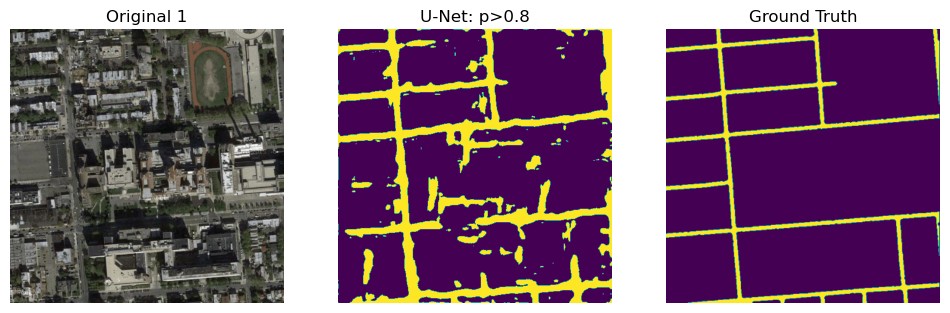

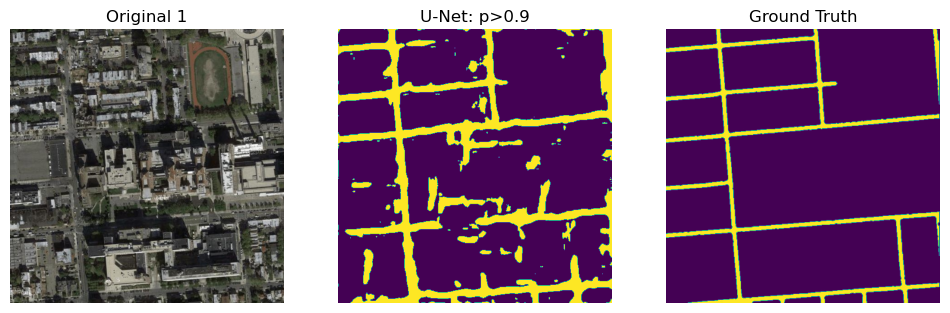

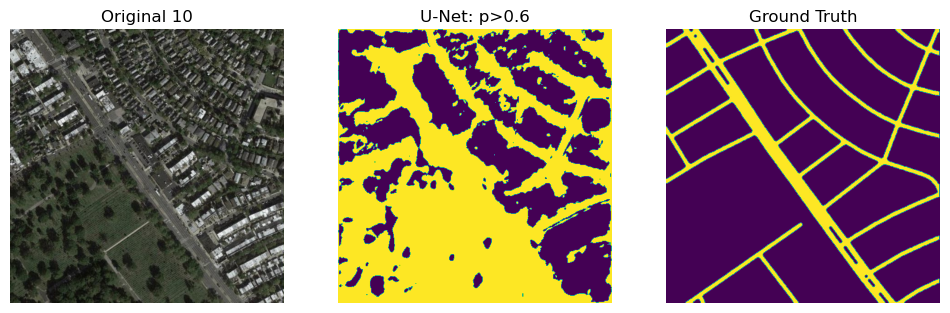

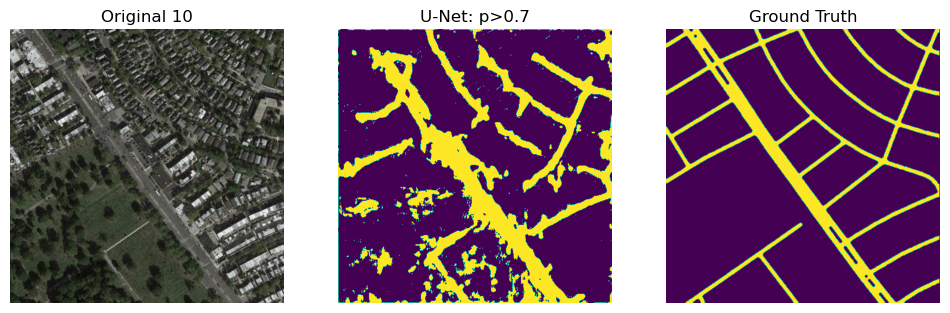

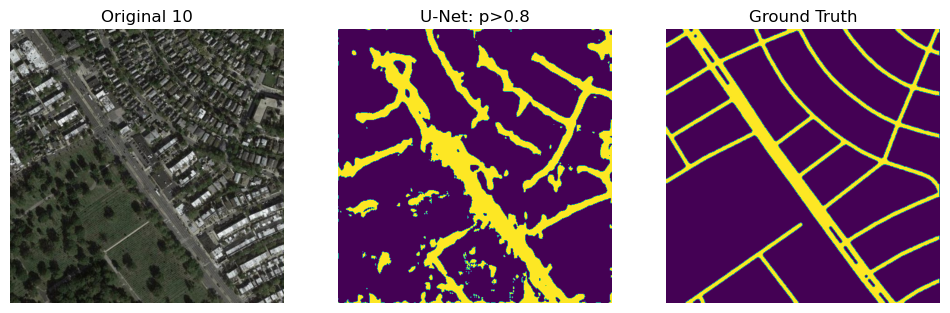

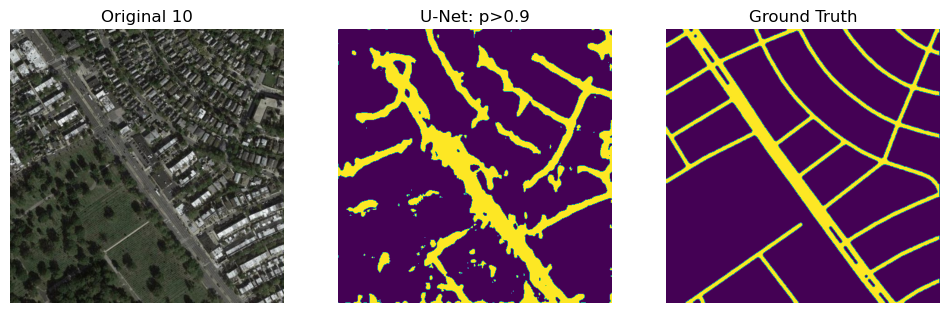

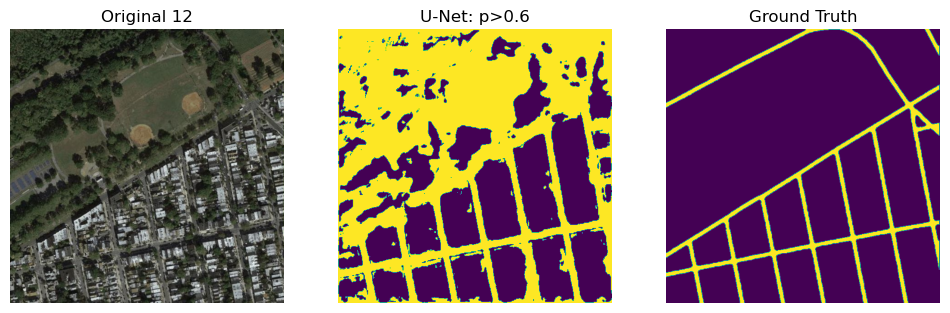

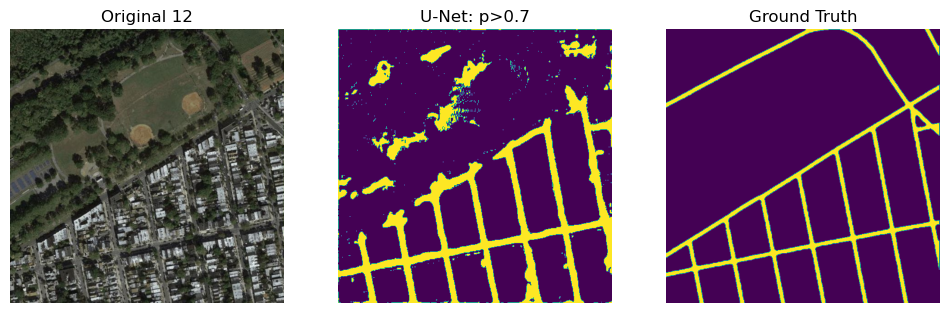

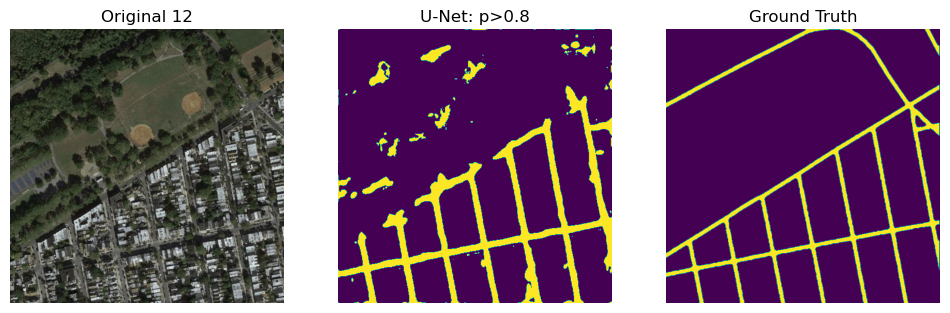

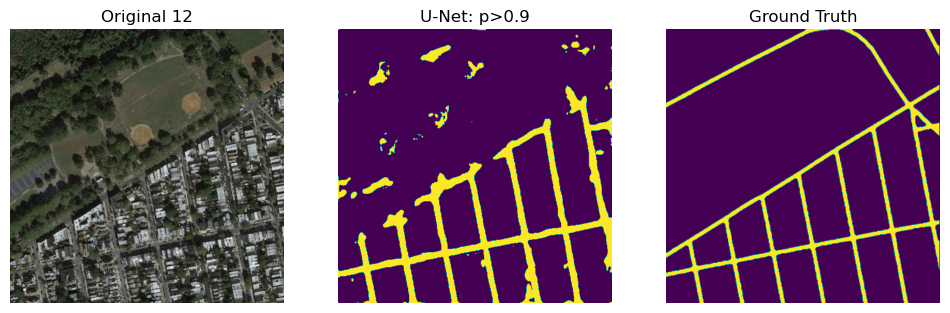

In [25]:
show_test_idx = random.sample(range(len(unet_predictT)), 3)
for idx in show_test_idx: 
    show_result(idx, test_images[idx], unet_predict1[idx], test_masks[idx], r1)
    show_result(idx, test_images[idx], unet_predict2[idx], test_masks[idx], r2)
    show_result(idx, test_images[idx], unet_predict3[idx], test_masks[idx], r3)
    show_result(idx, test_images[idx], unet_predict4[idx], test_masks[idx], r4)
    print()